---

Load essential libraries

---

In [1]:
import pandas as pd
import numpy as np
import math
import os
import sys
import datetime
import h5py 
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as dates
from scipy.fft import fft
from scipy.stats import skew, kurtosis, entropy
plt.style.use('dark_background')
%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 4.0) # set default size of plots

---

Mount Google Drive folder if running Google Colab

---

In [2]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/Research/MSIS_RandD/Hydraulics'
    DATA_DIR = DIR + '/Data/'
else:
    DATA_DIR = 'Data/'

---

Read multiple sensor data from the hydraulics dataset

---

In [3]:
# List of sensor files with the file path
sensor_files = ['PS1.txt', 'FS1.txt', 'TS1.txt']

# Create an empty dictionary to store the sensor files data
#Path(f).stem removes .txt → creates keys like 'PS1', 'FS1', 'TS1'.
data = dict.fromkeys([Path(f).stem for f in sensor_files])

# Read data from each sensor
for (sensor, value), file in zip(data.items(), sensor_files):
  data[sensor] = pd.read_csv(DATA_DIR + file, sep = "\t", header = None)

---

Create HDF5 file for the multivariate timeseries data 

In [4]:
# Create a didctionary with file name of the sensors


sensor_files = {'PS1':'PS1.txt', 'PS2':'PS2.txt', 'PS3':'PS3.txt', 'PS4':'PS4.txt', 'PS5':'PS5.txt',
                'PS6':'PS6.txt', 'EPS1':'EPS1.txt', 'FS1':'FS1.txt', 'FS2':'FS2.txt','TS1':'TS1.txt',
                'TS2':'TS2.txt', 'TS3':'TS3.txt', 'TS4':'TS4.txt', 'VS1':'VS1.txt', 'CE':'CE.txt','CP':'CP.txt','SE':'SE.txt'}

#print(sensor_files)

label_file = DATA_DIR + 'profile.txt'
output_file = DATA_DIR + 'hydraluic_dataset.h5' # what's this file extaxtly then?

# create a dictionary for the metadaa
sensor_meta={ 'PS1':('Pressure','bar',100),
              'PS2':('Pressure','bar',100),
              'PS3':('Pressure','bar',100),
              'PS4':('Pressure','bar',100),
              'PS5':('Pressure','bar',100),
              'PS6':('Pressure','bar',100),
              'EPS1':('Pressure','bar',100),
              'FS1':('Flow','L/min',10),
              'FS2':('Flow','L/min',10),
              'TS1':('Temperature','C',1),
              'TS2':('Temperature','C',1),
              'TS3':('Temperature','C',1),
              'TS4':('Temperature','C',1),
              'VS1':('Vibration','m/s',1),
              'CE':('Cooling efficiency','percentage',1),
              'CP':('Cooling power','W',1),
              'SE':('Efficiency Factor','percentage',1)}


# read the lables
df_labels = pd.read_csv(label_file, delimiter = '\t', header = None)
df_labels.columns = ['cooler_condition', 'valve_condition', 'pump_leakage', 'accumulator_pressure', 'stable_flag']



In [5]:
sensor_data = {}
for name, fname in sensor_files.items():
    sensor_data[name]= np.loadtxt( DATA_DIR + fname, delimiter = '\t')

# write to hdf5 file
with h5py.File(output_file, 'w') as h5f:
    # Raw group
    raw_group = h5f.create_group('raw')
    
    for sensorname, sensordata in sensor_data.items():
        raw_group.create_dataset(sensorname, data = sensordata, compression = 'gzip')
    #lables group
    
    labels_group = h5f.create_group('labels')
    for col in df_labels.columns:
        labels_group.create_dataset(col,  data = df_labels[col].values, compression = 'gzip')
        
    #metadata group
    
    metadata_group = h5f.create_group('metadata')
    metadata_group.create_dataset('sensor_names', data = np.array(list(sensor_meta.keys()), dtype = 'S'))
    metadata_group.create_dataset('units', data = np.array([v[1] for v in sensor_meta.values()], dtype = 'S'))
    metadata_group.create_dataset('Smpling_rate', data = np.array([v[2] for v in sensor_meta.values()],dtype = 'S'))
    
    metadata_group.attrs['description'] = 'Hydraluic condition monitoring dataset with multiple sesnsor data'

In [6]:
[v[1] for v in sensor_meta.values()]
 

['bar',
 'bar',
 'bar',
 'bar',
 'bar',
 'bar',
 'bar',
 'L/min',
 'L/min',
 'C',
 'C',
 'C',
 'C',
 'm/s',
 'percentage',
 'W',
 'percentage']

Usage Examples

In [7]:
with h5py.File(output_file, 'r') as h5f:
    # print(f'SEnsor names {h5f['/raw'].keys()}')
    # print(f'Label names {h5f['/labels'].keys()}')
     print(f'Description: {h5f['/metadata'].attrs['description']}')
    
     print(h5f['raw/PS1'][0:5])
     print(h5f['/labels/cooler_condition'][:10])
    #print(h5f['raw/PS1'][0][:3000])

Description: Hydraluic condition monitoring dataset with multiple sesnsor data
[[151.47 151.45 151.52 ... 151.1  151.21 151.19]
 [151.11 151.12 151.16 ... 150.79 150.8  150.86]
 [150.81 150.79 150.84 ... 150.43 150.54 150.62]
 [150.48 150.47 150.52 ... 150.31 150.25 150.28]
 [150.41 150.35 150.24 ... 150.22 150.13 150.19]]
[3 3 3 3 3 3 3 3 3 3]


In [8]:
data[sensor]

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,35.570,35.492,35.469,35.422,35.414,35.320,35.227,35.242,35.160,35.176,...,36.008,35.984,35.996,36.039,36.008,36.008,36.094,36.102,36.090,36.152
1,36.156,36.094,35.992,36.008,35.992,35.902,35.824,35.820,35.727,35.727,...,37.328,37.324,37.340,37.332,37.316,37.410,37.418,37.422,37.488,37.477
2,37.488,37.391,37.340,37.312,37.223,37.145,37.059,36.973,36.898,36.879,...,38.457,38.461,38.457,38.469,38.469,38.555,38.527,38.543,38.527,38.621
3,38.633,38.535,38.469,38.379,38.297,38.223,38.125,38.062,37.977,37.969,...,39.441,39.363,39.367,39.457,39.461,39.461,39.473,39.441,39.453,39.461
4,39.461,39.461,39.375,39.281,39.203,39.113,39.043,38.969,38.875,38.883,...,40.324,40.320,40.312,40.340,40.320,40.387,40.391,40.391,40.387,40.391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,35.414,35.348,35.254,35.262,35.168,35.172,35.105,35.094,35.000,35.008,...,35.426,35.516,35.437,35.426,35.410,35.414,35.414,35.426,35.414,35.414
2201,35.434,35.332,35.266,35.195,35.262,35.195,35.082,35.105,34.988,35.008,...,35.434,35.434,35.449,35.414,35.422,35.414,35.426,35.437,35.402,35.398
2202,35.434,35.355,35.262,35.187,35.266,35.102,35.105,35.094,35.016,35.016,...,35.500,35.434,35.410,35.434,35.426,35.437,35.441,35.410,35.434,35.437
2203,35.449,35.359,35.277,35.184,35.195,35.184,35.105,35.016,35.012,35.008,...,35.437,35.531,35.426,35.516,35.422,35.441,35.461,35.414,35.426,35.441


FEATURE EXTRACTION - FOURIER TRANSFORM

In [8]:
# ================================================================
#  HYDRAULIC SYSTEM - FFT FEATURE EXTRACTION PIPELINE
# ================================================================
#  Description:
#   - Loads hydraulic condition monitoring dataset (.h5)
#   - Extracts time-domain and frequency-domain (FFT) features
#   - Stores results as a single CSV for ML or anomaly detection
# ================================================================

import h5py
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.fft import fft, fftfreq
from tqdm import tqdm
import os

# ------------------------------------------------
# STEP 1: Define File Path
# ------------------------------------------------
file_path = "Data/hydraluic_dataset.h5"  # Update this if path differs (e.g. "Data/hydraluic_dataset.h5")

if not os.path.exists(file_path):
    raise FileNotFoundError(f"HDF5 dataset not found at: {file_path}")

print(f" Using dataset file: {file_path}")

# ------------------------------------------------
# STEP 2: Open the HDF5 File for reading & collects all sensor names and Display the number and names loaded sensors
# ------------------------------------------------
with h5py.File(file_path, 'r') as h5f: 
    sensors = list(h5f['raw'].keys()) 
    print(f"Found {len(sensors)} sensors: {sensors}") 
    # Extract sampling rates from metadata
    sensor_names = [x.decode() for x in h5f['metadata']['sensor_names'][:]] 
    sampling_rates = [int(x.decode()) for x in h5f['metadata']['Smpling_rate'][:]] 
    rate_map = dict(zip(sensor_names, sampling_rates)) 

    # ------------------------------------------------
    # STEP 3: Define Feature Extraction Function
    # ------------------------------------------------
    def extract_features_from_signal(signal, sampling_rate): 
        """Extract time-domain and frequency-domain (FFT) features."""
        
        # quantify signal properties relevant to fault detection.
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        skew_val = skew(signal)
        kurt_val = kurtosis(signal)
        rms_val = np.sqrt(np.mean(signal**2))
        energy_val = np.sum(signal**2) / len(signal)
        peak_to_peak = np.ptp(signal)

        # --- Frequency-Domain (FFT) Features[it's spectrum] --- #FFT-based frequency domain features (dominant frequency, spectral energy, entropy)
        freq = fftfreq(len(signal), d=1/sampling_rate)
        spectrum = np.abs(fft(signal))
        spectrum = spectrum[:len(spectrum)//2]  
        freq = freq[:len(freq)//2]

        dom_freq = freq[np.argmax(spectrum)]
        spectral_energy = np.sum(spectrum**2)
        psd = spectrum / np.sum(spectrum)  # Power Spectral Density.- tell's you the distribution of the signal's power across the frequency spectrum
        spectral_entropy = -np.sum(psd * np.log(psd + 1e-10))  # entropy measure

        return {
            'mean': mean_val,
            'std': std_val,
            'skew': skew_val,
            'kurtosis': kurt_val,
            'rms': rms_val,
            'energy': energy_val,
            'peak_to_peak': peak_to_peak,
            'dominant_freq': dom_freq,
            'spectral_energy': spectral_energy,
            'spectral_entropy': spectral_entropy
        }

    # ------------------------------------------------
    # STEP 4: Extract Features from All Sensors
    # iterates over all the sensors , and extarcts its raw data (n_cycles, n_samples) and gets the sample data
    # ------------------------------------------------
    feature_rows = [] 

    for sensor in sensors:  
        data = h5f[f'raw/{sensor}'][:]  
        sampling_rate = rate_map.get(sensor, 100)

        print(f"\nExtracting features for {sensor}: "
              f"{data.shape[0]} cycles × {data.shape[1]} samples @ {sampling_rate} Hz") 
        # here tqdm a lib in pyhton , provides a progress bar for usability
        for cycle_idx in tqdm(range(data.shape[0]), desc=f"Processing {sensor}"): 
            signal = data[cycle_idx, :]
            features = extract_features_from_signal(signal, sampling_rate)
            features['sensor'] = sensor
            features['cycle'] = cycle_idx
            feature_rows.append(features)
            

# ------------------------------------------------
# STEP 5: Combine All Features into DataFrame
# ------------------------------------------------
features_df = pd.DataFrame(feature_rows)
print(f"\n Extracted {features_df.shape[0]} feature rows × {features_df.shape[1]} columns.")

# Handle any NaNs caused by flat signals
features_df.fillna(0, inplace=True)

# ------------------------------------------------
# STEP 6: Save Extracted Features to CSV
# ------------------------------------------------
os.makedirs("Data", exist_ok=True)
output_csv = "Data/hydraulic_fft_features.csv"
features_df.to_csv(output_csv, index=False)
print(f" Features successfully saved to: {output_csv}")

# ------------------------------------------------
# STEP 7: Display Preview of Extracted Features
# ------------------------------------------------
print("\n🔹 Preview of Extracted FFT Features:")
print(features_df.head())


 Using dataset file: Data/hydraluic_dataset.h5
Found 17 sensors: ['CE', 'CP', 'EPS1', 'FS1', 'FS2', 'PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'SE', 'TS1', 'TS2', 'TS3', 'TS4', 'VS1']

Extracting features for CE: 2205 cycles × 60 samples @ 1 Hz


Processing CE: 100%|██████████| 2205/2205 [00:04<00:00, 531.03it/s]



Extracting features for CP: 2205 cycles × 60 samples @ 1 Hz


Processing CP: 100%|██████████| 2205/2205 [00:04<00:00, 541.61it/s]



Extracting features for EPS1: 2205 cycles × 6000 samples @ 100 Hz


Processing EPS1: 100%|██████████| 2205/2205 [00:04<00:00, 513.54it/s]



Extracting features for FS1: 2205 cycles × 600 samples @ 10 Hz


Processing FS1: 100%|██████████| 2205/2205 [00:03<00:00, 665.19it/s]



Extracting features for FS2: 2205 cycles × 600 samples @ 10 Hz


Processing FS2: 100%|██████████| 2205/2205 [00:06<00:00, 338.47it/s]



Extracting features for PS1: 2205 cycles × 6000 samples @ 100 Hz


Processing PS1: 100%|██████████| 2205/2205 [00:05<00:00, 402.79it/s]



Extracting features for PS2: 2205 cycles × 6000 samples @ 100 Hz


Processing PS2: 100%|██████████| 2205/2205 [00:05<00:00, 427.12it/s]



Extracting features for PS3: 2205 cycles × 6000 samples @ 100 Hz


Processing PS3: 100%|██████████| 2205/2205 [00:04<00:00, 528.24it/s]



Extracting features for PS4: 2205 cycles × 6000 samples @ 100 Hz


Processing PS4:   0%|          | 0/2205 [00:00<?, ?it/s]C:\Users\Prasanna\AppData\Local\Temp\ipykernel_108228\1306671072.py:62: RuntimeWarning: invalid value encountered in divide
  psd = spectrum / np.sum(spectrum)  # Power Spectral Density.- tell's you the distribution of the signal's power across the frequency spectrum
Processing PS4: 100%|██████████| 2205/2205 [00:04<00:00, 534.95it/s]



Extracting features for PS5: 2205 cycles × 6000 samples @ 100 Hz


Processing PS5: 100%|██████████| 2205/2205 [00:04<00:00, 517.42it/s]



Extracting features for PS6: 2205 cycles × 6000 samples @ 100 Hz


Processing PS6: 100%|██████████| 2205/2205 [00:04<00:00, 514.89it/s]



Extracting features for SE: 2205 cycles × 60 samples @ 1 Hz


Processing SE: 100%|██████████| 2205/2205 [00:02<00:00, 736.78it/s]



Extracting features for TS1: 2205 cycles × 60 samples @ 1 Hz


Processing TS1: 100%|██████████| 2205/2205 [00:03<00:00, 675.87it/s]



Extracting features for TS2: 2205 cycles × 60 samples @ 1 Hz


Processing TS2: 100%|██████████| 2205/2205 [00:03<00:00, 687.05it/s]



Extracting features for TS3: 2205 cycles × 60 samples @ 1 Hz


Processing TS3: 100%|██████████| 2205/2205 [00:03<00:00, 681.09it/s]



Extracting features for TS4: 2205 cycles × 60 samples @ 1 Hz


Processing TS4: 100%|██████████| 2205/2205 [00:03<00:00, 679.52it/s]



Extracting features for VS1: 2205 cycles × 60 samples @ 1 Hz


Processing VS1: 100%|██████████| 2205/2205 [00:03<00:00, 719.53it/s]



 Extracted 37485 feature rows × 12 columns.
 Features successfully saved to: Data/hydraulic_fft_features.csv

🔹 Preview of Extracted FFT Features:
        mean       std      skew  kurtosis        rms       energy  \
0  39.601350  6.317224 -0.267015 -1.419685  40.102048  1608.174244   
1  25.786433  1.672019  0.401015 -1.097494  25.840584   667.735792   
2  22.218233  0.633003  0.304239 -1.103712  22.227249   494.050586   
3  20.459817  0.451941  0.183835 -0.251527  20.464808   418.808349   
4  19.787017  0.287728 -0.025580 -0.073937  19.789109   391.608816   

   peak_to_peak  dominant_freq  spectral_energy  spectral_entropy sensor  \
0        18.572            0.0     5.717561e+06          1.259132     CE   
1         5.888            0.0     2.398814e+06          0.766848     CE   
2         2.334            0.0     1.777857e+06          0.426167     CE   
3         1.892            0.0     1.507341e+06          0.351090     CE   
4         1.327            0.0     1.409640e+06    

In [9]:
# ================================================================
#  HYDRAULIC SYSTEM - MERGING FFT FEATURES WITH CONDITION LABELS
# ================================================================
#  This script merges extracted features (from FFT) with target labels
#  from hydraluic_dataset.h5 to form a Machine Learning-ready dataset
# ================================================================

import h5py
import pandas as pd
import numpy as np
import os

# ------------------------------------------------
# STEP 1: Load Files
# ------------------------------------------------
h5_file = "Data/hydraluic_dataset.h5"
features_csv = "Data/hydraulic_fft_features.csv"

if not os.path.exists(h5_file):
    raise FileNotFoundError(f"HDF5 dataset not found: {h5_file}")

if not os.path.exists(features_csv):
    raise FileNotFoundError(f"Feature CSV not found: {features_csv}")

print(f" Using HDF5 file: {h5_file}")
print(f" Using features file: {features_csv}")

# ------------------------------------------------
# STEP 2: Load Extracted Features
# ------------------------------------------------
features_df = pd.read_csv(features_csv)
print(f"\nLoaded {features_df.shape[0]} feature rows from CSV.")

# ------------------------------------------------
# STEP 3: Load Labels from HDF5
# ------------------------------------------------
with h5py.File(h5_file, 'r') as h5f:
    labels = {}
    for label_name in h5f['labels'].keys():
        labels[label_name] = h5f['labels'][label_name][:]

# Convert label dict → DataFrame
labels_df = pd.DataFrame(labels)
labels_df.reset_index(inplace=True)
labels_df.rename(columns={'index': 'cycle'}, inplace=True)

print(f"Loaded labels with shape: {labels_df.shape}")
print(labels_df.head())

# ------------------------------------------------
# STEP 4: Merge Features with Labels
# ------------------------------------------------
# Each feature row corresponds to a sensor × cycle pair.
# Labels are same for all sensors for the same cycle number.
merged_df = pd.merge(features_df, labels_df, on='cycle', how='left')

print(f"\n  Merged dataset shape: {merged_df.shape}")
print("Preview of merged dataset:")
print(merged_df.head())

# ------------------------------------------------
# STEP 5: Save Final ML-Ready Dataset
# ------------------------------------------------
os.makedirs("Data", exist_ok=True)
output_csv = "Data/hydraulic_features_with_labels.csv"
merged_df.to_csv(output_csv, index=False)

print(f"\n Final ML-Ready dataset saved to: {output_csv}")

# ------------------------------------------------
# STEP 6: (Optional) Check Label Distribution
# ------------------------------------------------
print("\nLabel summary:")
for col in ['cooler_condition', 'valve_condition', 'pump_leakage', 'accumulator_pressure', 'stable_flag']:
    if col in merged_df.columns:
        print(f"{col}: unique values = {merged_df[col].unique()}")


 Using HDF5 file: Data/hydraluic_dataset.h5
 Using features file: Data/hydraulic_fft_features.csv

Loaded 37485 feature rows from CSV.
Loaded labels with shape: (2205, 6)
   cycle  accumulator_pressure  cooler_condition  pump_leakage  stable_flag  \
0      0                   130                 3             0            1   
1      1                   130                 3             0            1   
2      2                   130                 3             0            1   
3      3                   130                 3             0            1   
4      4                   130                 3             0            1   

   valve_condition  
0              100  
1              100  
2              100  
3              100  
4              100  

  Merged dataset shape: (37485, 17)
Preview of merged dataset:
        mean       std      skew  kurtosis        rms       energy  \
0  39.601350  6.317224 -0.267015 -1.419685  40.102048  1608.174244   
1  25.786433  1.672019  

PHASE 3: Machine Learning Model for Condition Monitoring

MODEL TRAINING AND EVALUATION

 Loaded dataset with shape: (37485, 17)
Training samples: 28113 | Testing samples: 9372

🌲 Random Forest Results:
              precision    recall  f1-score   support

           0       0.86      0.72      0.78      5190
           1       0.53      0.61      0.57      2091
           2       0.51      0.64      0.57      2091

    accuracy                           0.68      9372
   macro avg       0.63      0.66      0.64      9372
weighted avg       0.71      0.68      0.69      9372



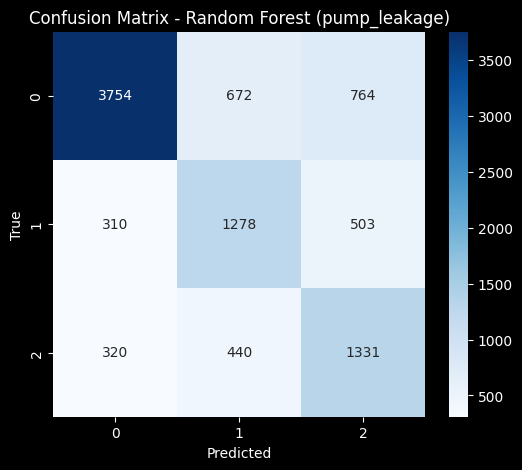


 XGBoost Results:
              precision    recall  f1-score   support

           0       0.81      0.93      0.86      5190
           1       0.68      0.56      0.61      2091
           2       0.71      0.56      0.63      2091

    accuracy                           0.77      9372
   macro avg       0.73      0.68      0.70      9372
weighted avg       0.76      0.77      0.76      9372



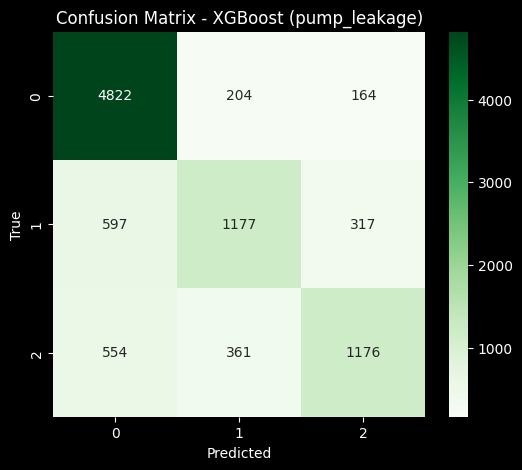

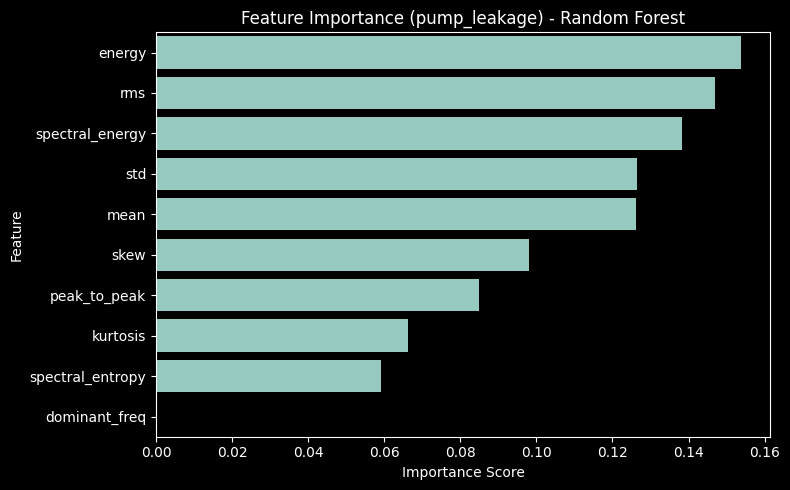


 Models saved: random_forest_pump_leakage.pkl, xgboost_pump_leakage.pkl

 Phase 3 completed successfully!


In [10]:
# ================================================================
#  HYDRAULIC SYSTEM CONDITION MONITORING
#  (PHASE 3: MODEL BUILDING & EVALUATION)
# ================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# ------------------------------------------------
# STEP 1: Load ML-Ready Dataset
# ------------------------------------------------
dataset_path = "Data/hydraulic_features_with_labels.csv"
df = pd.read_csv(dataset_path)
print(f" Loaded dataset with shape: {df.shape}")

# ------------------------------------------------
# STEP 2: Choose a Target Variable
# ------------------------------------------------
# Possible targets: 'cooler_condition', 'valve_condition', 'pump_leakage', 'accumulator_pressure'
target = 'pump_leakage'  # You can change this to any other condition label

# Keep only numeric features
feature_cols = [
    'mean', 'std', 'skew', 'kurtosis', 'rms', 'energy',
    'peak_to_peak', 'dominant_freq', 'spectral_energy', 'spectral_entropy'
]

# Create feature and target matrices
X = df[feature_cols]
y = df[target]

# ------------------------------------------------
# STEP 3: Split Train/Test Sets
# ------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"Training samples: {X_train.shape[0]} | Testing samples: {X_test.shape[0]}")

# ------------------------------------------------
# STEP 4: Train a Random Forest Model
# ------------------------------------------------
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n🌲 Random Forest Results:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - Random Forest ({target})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ------------------------------------------------
# STEP 5: Train an XGBoost Model (optional advanced model)
# ------------------------------------------------
xgb = XGBClassifier(
    n_estimators=250,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\n XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix for XGBoost
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Greens')
plt.title(f"Confusion Matrix - XGBoost ({target})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ------------------------------------------------
# STEP 6: Feature Importance Visualization
# ------------------------------------------------
feature_importance = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title(f"Feature Importance ({target}) - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ------------------------------------------------
# STEP 7: Optional - Save Trained Models
# ------------------------------------------------
import joblib
joblib.dump(rf, f"Data/random_forest_{target}.pkl")
joblib.dump(xgb, f"Data/xgboost_{target}.pkl")
print(f"\n Models saved: random_forest_{target}.pkl, xgboost_{target}.pkl")

print("\n Phase 3 completed successfully!")


 Dataset loaded successfully: 37485 rows, 17 columns

 Training model for: cooler_condition

 Accuracy: 0.960
 Weighted F1-Score: 0.960

Detailed Classification Report:
              precision    recall  f1-score   support

           3       0.97      0.92      0.94      3111
          20       0.92      0.97      0.95      3111
         100       0.99      0.99      0.99      3150

    accuracy                           0.96      9372
   macro avg       0.96      0.96      0.96      9372
weighted avg       0.96      0.96      0.96      9372



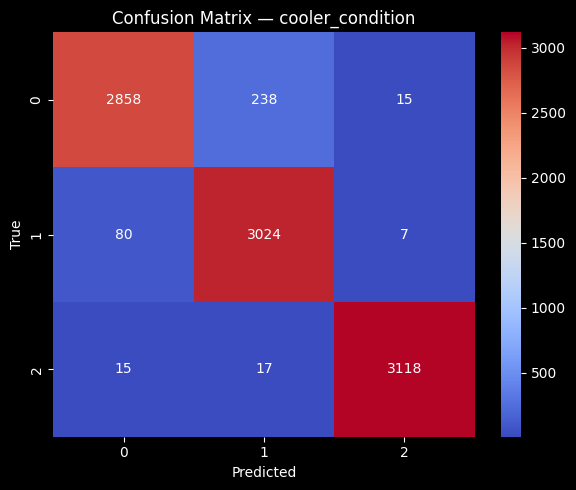

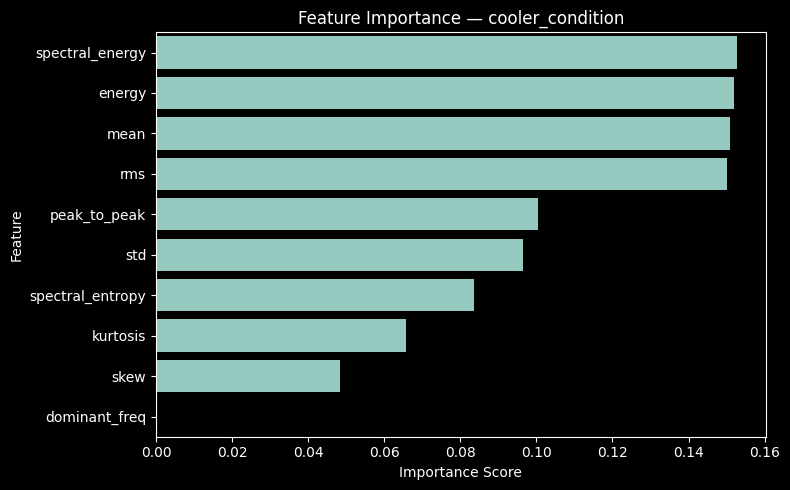

 Model saved: Data/random_forest_cooler_condition.pkl

 Training model for: valve_condition

 Accuracy: 0.587
 Weighted F1-Score: 0.599

Detailed Classification Report:
              precision    recall  f1-score   support

          73       0.44      0.54      0.48      1530
          80       0.45      0.46      0.46      1530
          90       0.38      0.47      0.42      1530
         100       0.81      0.68      0.74      4782

    accuracy                           0.59      9372
   macro avg       0.52      0.54      0.52      9372
weighted avg       0.62      0.59      0.60      9372



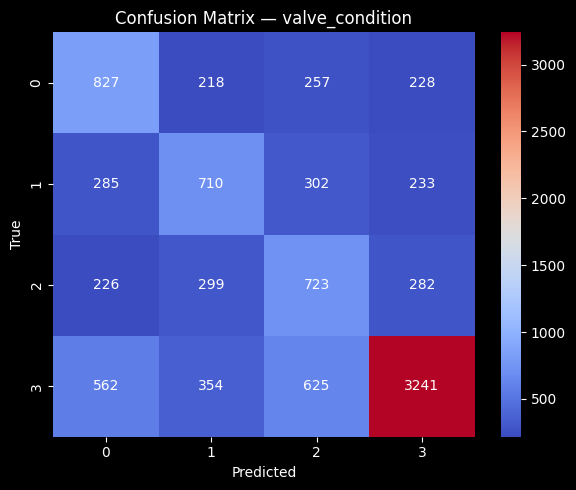

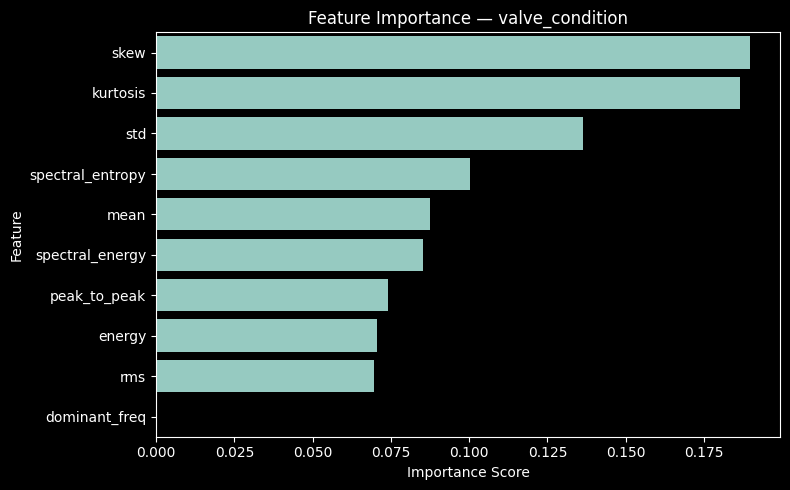

 Model saved: Data/random_forest_valve_condition.pkl

 Training model for: pump_leakage

 Accuracy: 0.709
 Weighted F1-Score: 0.716

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      5190
           1       0.55      0.66      0.60      2091
           2       0.56      0.64      0.60      2091

    accuracy                           0.71      9372
   macro avg       0.66      0.68      0.67      9372
weighted avg       0.73      0.71      0.72      9372



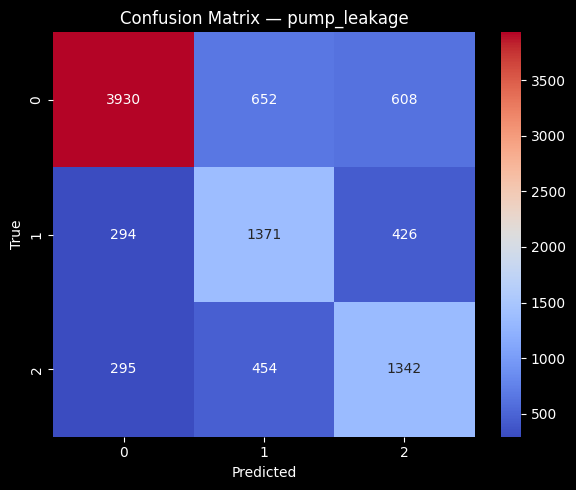

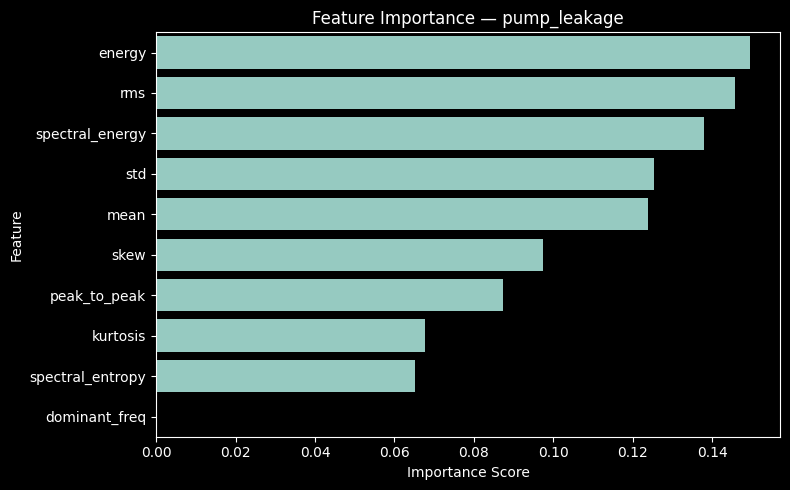

 Model saved: Data/random_forest_pump_leakage.pkl

 Training model for: accumulator_pressure

 Accuracy: 0.719
 Weighted F1-Score: 0.723

Detailed Classification Report:
              precision    recall  f1-score   support

          90       0.82      0.72      0.77      3434
         100       0.56      0.69      0.62      1696
         115       0.62      0.64      0.63      1696
         130       0.80      0.79      0.79      2546

    accuracy                           0.72      9372
   macro avg       0.70      0.71      0.70      9372
weighted avg       0.73      0.72      0.72      9372



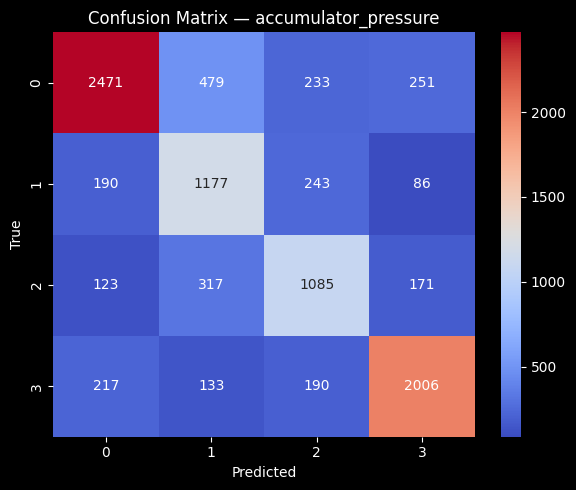

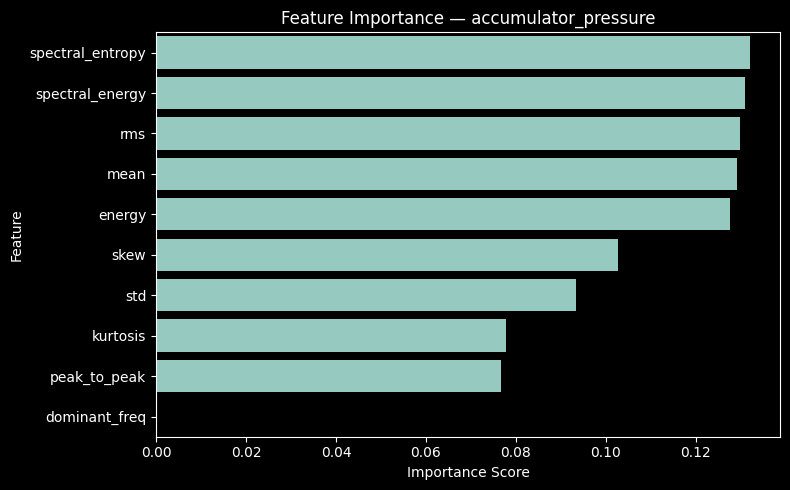

 Model saved: Data/random_forest_accumulator_pressure.pkl

 Model Performance Summary:
                 Target  Accuracy  F1_Score       Top_Feature
0      cooler_condition     0.960     0.960   spectral_energy
1       valve_condition     0.587     0.599              skew
2          pump_leakage     0.709     0.716            energy
3  accumulator_pressure     0.719     0.723  spectral_entropy


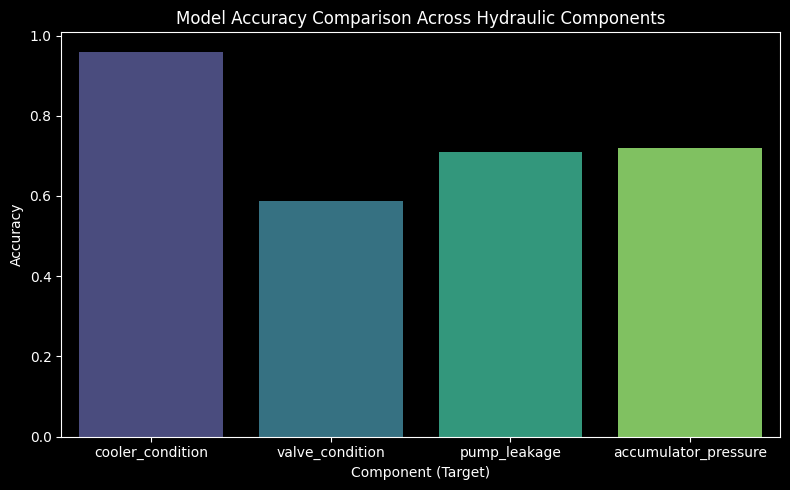

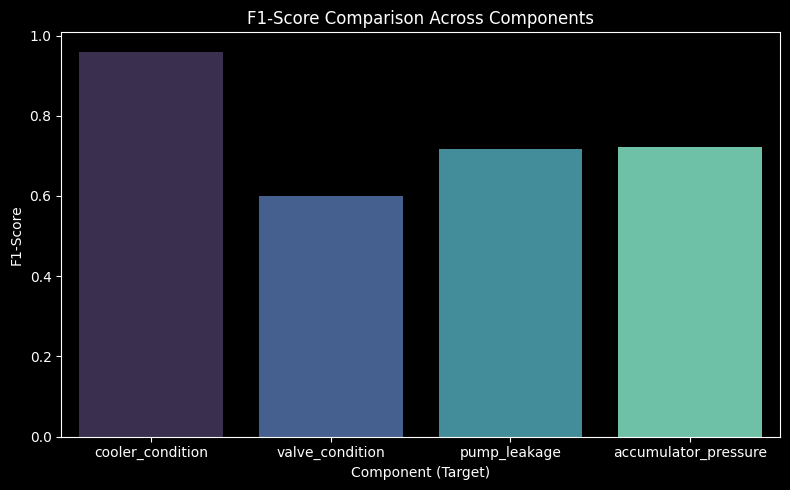


 Performance summary saved to: Data/model_performance_summary.csv

 Phase 3 completed — All component models trained, evaluated, and saved successfully!


In [11]:
# ================================================================
#  HYDRAULIC SYSTEM CONDITION MONITORING
#  (PHASE 3: MULTI-TARGET MODEL BUILDING & EVALUATION)
# ================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------
# STEP 1: Load the ML-Ready Dataset
# ------------------------------------------------
dataset_path = "Data/hydraulic_features_with_labels.csv"
df = pd.read_csv(dataset_path)
print(f" Dataset loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")

# ------------------------------------------------
# STEP 2: Define Feature Columns and Targets
# ------------------------------------------------
feature_cols = [
    'mean', 'std', 'skew', 'kurtosis', 'rms', 'energy',
    'peak_to_peak', 'dominant_freq', 'spectral_energy', 'spectral_entropy'
]

targets = ['cooler_condition', 'valve_condition', 'pump_leakage', 'accumulator_pressure']
results_summary = []

# ------------------------------------------------
# STEP 3: Train & Evaluate Models for Each Target
# ------------------------------------------------
for target in targets:
    print("\n" + "="*65)
    print(f" Training model for: {target}")
    print("="*65)

    # Prepare features and labels
    X = df[feature_cols]
    y = df[target]

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y if len(np.unique(y)) > 2 else None
    )

    # Initialize model
    rf = RandomForestClassifier(
        n_estimators=250,
        max_depth=14,
        random_state=42,
        class_weight='balanced_subsample'
    )

    # Train
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n Accuracy: {acc:.3f}")
    print(f" Weighted F1-Score: {f1:.3f}")
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='coolwarm')
    plt.title(f"Confusion Matrix — {target}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Feature Importance
    importance = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=importance, y=importance.index)
    plt.title(f"Feature Importance — {target}")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # Save model
    model_path = f"Data/random_forest_{target}.pkl"
    joblib.dump(rf, model_path)
    print(f" Model saved: {model_path}")

    # Store summary
    results_summary.append({
        'Target': target,
        'Accuracy': round(acc, 3),
        'F1_Score': round(f1, 3),
        'Top_Feature': importance.index[0]
    })

# ------------------------------------------------
# STEP 4: Summary Comparison Across All Components
# ------------------------------------------------
summary_df = pd.DataFrame(results_summary)
print("\n Model Performance Summary:")
print(summary_df)

# Visualize comparison
plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x='Target', y='Accuracy', palette='viridis')
plt.title("Model Accuracy Comparison Across Hydraulic Components")
plt.ylabel("Accuracy")
plt.xlabel("Component (Target)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x='Target', y='F1_Score', palette='mako')
plt.title("F1-Score Comparison Across Components")
plt.ylabel("F1-Score")
plt.xlabel("Component (Target)")
plt.tight_layout()
plt.show()

# Save summary
summary_path = "Data/model_performance_summary.csv"
summary_df.to_csv(summary_path, index=False)
print(f"\n Performance summary saved to: {summary_path}")

print("\n Phase 3 completed — All component models trained, evaluated, and saved successfully!")


 Loaded dataset. Shape: (37485, 17)

 PROCESSING TARGET: Cooler (cooler_condition)


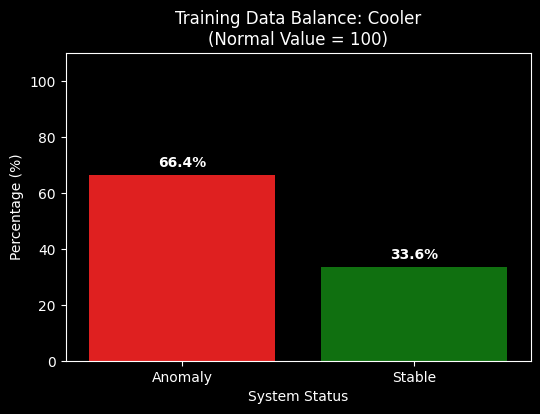

 Classification Report for Cooler:
              precision    recall  f1-score   support

     Anomaly       1.00      1.00      1.00      6222
      Stable       0.99      0.99      0.99      3150

    accuracy                           1.00      9372
   macro avg       1.00      0.99      0.99      9372
weighted avg       1.00      1.00      1.00      9372

Confusion Matrix (Stable vs Anomaly):
[[3124   26]
 [  17 6205]]
------------------------------

 PROCESSING TARGET: Valve (valve_condition)


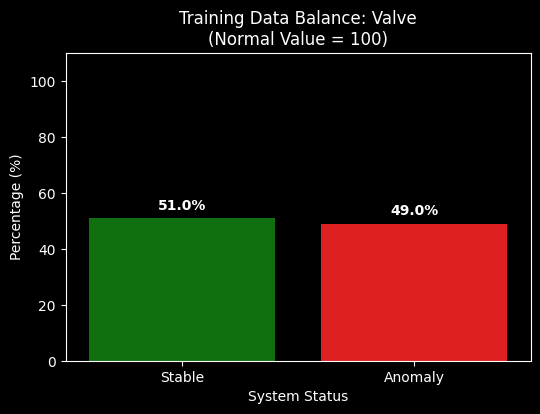

 Classification Report for Valve:
              precision    recall  f1-score   support

     Anomaly       0.78      0.81      0.80      4590
      Stable       0.81      0.79      0.80      4782

    accuracy                           0.80      9372
   macro avg       0.80      0.80      0.80      9372
weighted avg       0.80      0.80      0.80      9372

Confusion Matrix (Stable vs Anomaly):
[[3754 1028]
 [ 865 3725]]
------------------------------

 PROCESSING TARGET: Pump (pump_leakage)


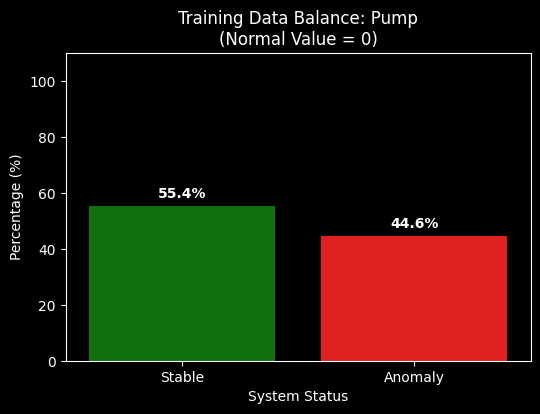

 Classification Report for Pump:
              precision    recall  f1-score   support

     Anomaly       0.85      0.83      0.84      4182
      Stable       0.87      0.88      0.87      5190

    accuracy                           0.86      9372
   macro avg       0.86      0.86      0.86      9372
weighted avg       0.86      0.86      0.86      9372

Confusion Matrix (Stable vs Anomaly):
[[4570  620]
 [ 703 3479]]
------------------------------

 PROCESSING TARGET: Accumulator (accumulator_pressure)


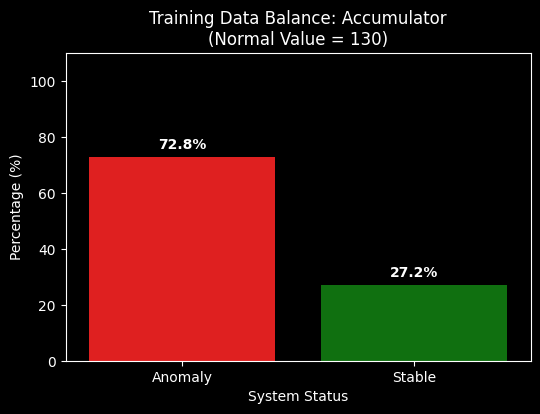

 Classification Report for Accumulator:
              precision    recall  f1-score   support

     Anomaly       0.93      0.94      0.93      6826
      Stable       0.83      0.81      0.82      2546

    accuracy                           0.90      9372
   macro avg       0.88      0.87      0.88      9372
weighted avg       0.90      0.90      0.90      9372

Confusion Matrix (Stable vs Anomaly):
[[2065  481]
 [ 430 6396]]
------------------------------

 All 4 conditions processed successfully!


In [12]:
# ================================================================
#  HYDRAULIC SYSTEM: MULTI-TARGET ANOMALY DETECTION
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------------------------
# 1. SETUP & DATA LOADING
# ------------------------------------------------
dataset_path = "Data/hydraulic_features_with_labels.csv"

try:
    df = pd.read_csv(dataset_path)
    print(f" Loaded dataset. Shape: {df.shape}")
except FileNotFoundError:
    print(" File not found. Generating dummy data for demonstration...")
    # Dummy data generation (Ignore this if you have the file)
    df = pd.DataFrame(np.random.rand(100, 10), columns=['mean', 'std', 'skew', 'kurtosis', 'rms', 'energy', 'peak_to_peak', 'dominant_freq', 'spectral_energy', 'spectral_entropy'])
    df['cooler_condition'] = np.random.choice([3, 20, 100], 100)
    df['valve_condition'] = np.random.choice([100, 90, 80, 73], 100)
    df['pump_leakage'] = np.random.choice([0, 1, 2], 100)
    df['accumulator_pressure'] = np.random.choice([130, 115, 100, 90], 100)

# Define the Numeric Features
feature_cols = [
    'mean', 'std', 'skew', 'kurtosis', 'rms', 'energy',
    'peak_to_peak', 'dominant_freq', 'spectral_energy', 'spectral_entropy'
]

# ------------------------------------------------
# 2. DEFINE "NORMAL" STATES
# ------------------------------------------------
# You must define what value represents a "Healthy/Stable" machine.
# Any value NOT in this list will be treated as an "Anomaly".
target_definitions = {
    'cooler_condition': {
        'normal_value': 100,   # 100% efficiency is stable
        'name': 'Cooler'
    },
    'valve_condition': {
        'normal_value': 100,   # 100% switching behavior is stable
        'name': 'Valve'
    },
    'pump_leakage': {
        'normal_value': 0,     # 0 leakage is stable
        'name': 'Pump'
    },
    'accumulator_pressure': {
        'normal_value': 130,   # 130 bar is optimal/stable
        'name': 'Accumulator'
    }
}

# ------------------------------------------------
# 3. LOOP THROUGH ALL 4 TARGETS
# ------------------------------------------------

for target_col, config in target_definitions.items():
    print(f"\n{'='*60}")
    print(f" PROCESSING TARGET: {config['name']} ({target_col})")
    print(f"{'='*60}")

    # --- A. Create Binary Target (Stable vs Anomaly) ---
    # If value == normal, Class is 0 (Stable). Else Class is 1 (Anomaly)
    # We create a temporary column for this loop
    binary_col_name = "output_label"
    
    df[binary_col_name] = df[target_col].apply(
        lambda x: 'Stable' if x == config['normal_value'] else 'Anomaly'
    )

    X = df[feature_cols]
    y = df[binary_col_name]

    # --- B. Stratified Split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    # --- C. Visualize Distribution (The Bar Plot You Asked For) ---
    plt.figure(figsize=(6, 4))
    
    # Calculate percentages
    counts = y_train.value_counts(normalize=True) * 100
    
    # Define colors: Green for Stable, Red for Anomaly
    palette = {"Stable": "green", "Anomaly": "red"}
    
    ax = sns.barplot(x=counts.index, y=counts.values, palette=palette)
    
    plt.title(f"Training Data Balance: {config['name']}\n(Normal Value = {config['normal_value']})")
    plt.ylabel("Percentage (%)")
    plt.xlabel("System Status")
    plt.ylim(0, 110) # Give space for text

    # Add percentage labels on bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontweight='bold')
    
    plt.show()
    
    # --- D. Train Model (Random Forest) ---
    rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # --- E. Results ---
    print(f" Classification Report for {config['name']}:")
    print(classification_report(y_test, y_pred))
    
    # Simple Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=['Stable', 'Anomaly'])
    print(f"Confusion Matrix (Stable vs Anomaly):\n{cm}")
    print("-" * 30)

print("\n All 4 conditions processed successfully!")

 Loaded dataset: 37485 rows, 17 columns
Normal samples: 170, Anomalous samples: 37315


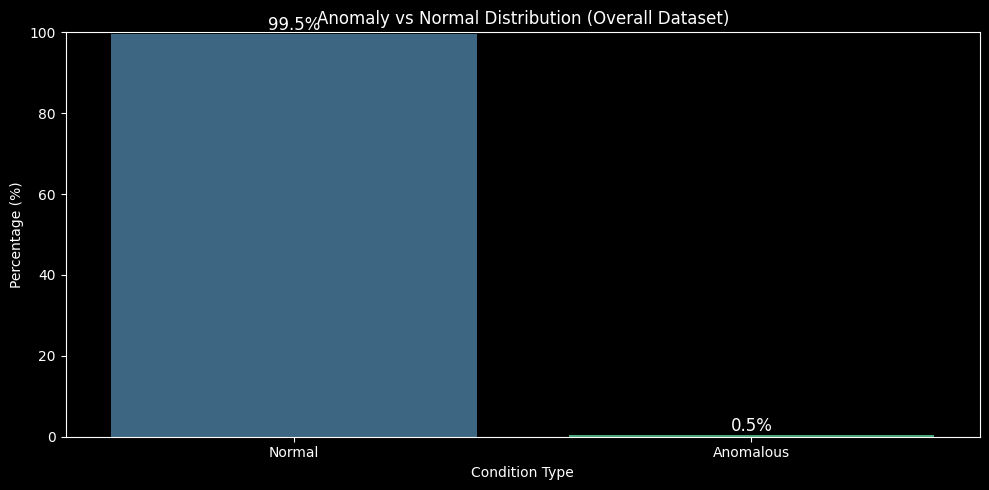

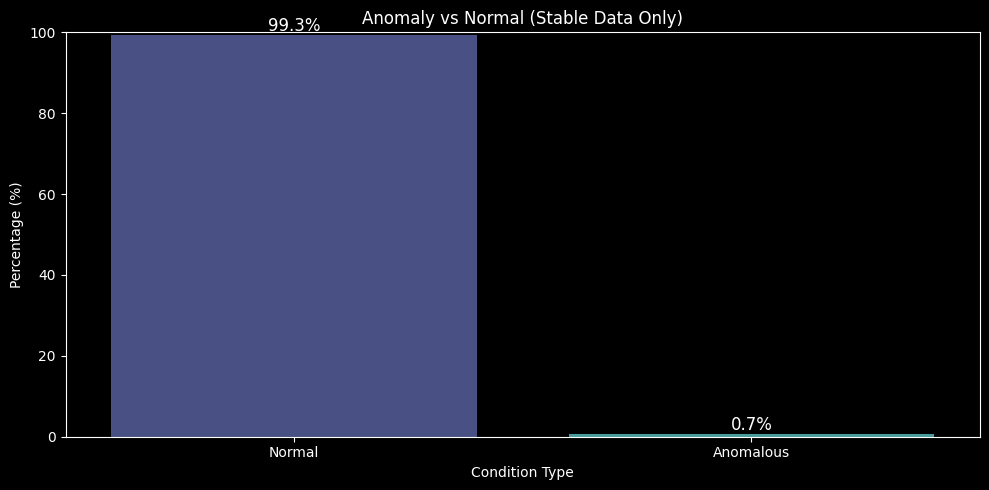


 Stratified Split Completed:
Training samples: 28113 | Testing samples: 9372
Training class distribution: [ 0.4517483 99.5482517]
Testing class distribution: [ 0.45881349 99.54118651]


In [13]:
# ================================================================
#  HYDRAULIC SYSTEM CONDITION MONITORING
#  (DATA BALANCE + STRATIFIED SPLIT + ANOMALY ANALYSIS)
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# ------------------------------------------------
# STEP 1: Load Data
# ------------------------------------------------
dataset_path = "Data/hydraulic_features_with_labels.csv"
df = pd.read_csv(dataset_path)
print(f" Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")

# ------------------------------------------------
# STEP 2: Define "Normal" vs "Anomalous" Conditions
# ------------------------------------------------
# Normal → stable flag = 0, no leakage, full efficiency, optimal valve & accumulator pressure
df['anomaly'] = 0  # Default = normal

# Mark anomalies based on condition deviations
df.loc[
    (df['pump_leakage'] > 0) | 
    (df['cooler_condition'] < 100) | 
    (df['valve_condition'] < 100) | 
    (df['accumulator_pressure'] < 130) |
    (df['stable_flag'] == 1),
    'anomaly'
] = 1

# Verify class distribution
total_normal = (df['anomaly'] == 0).sum()
total_anomalous = (df['anomaly'] == 1).sum()
print(f"Normal samples: {total_normal}, Anomalous samples: {total_anomalous}")

# ------------------------------------------------
# STEP 3: Visualize Anomaly vs Normal (Global)
# ------------------------------------------------
plt.figure(figsize=(10, 5))
counts = df['anomaly'].value_counts(normalize=True) * 100
sns.barplot(x=['Normal', 'Anomalous'], y=counts.values, palette='viridis')
plt.title("Anomaly vs Normal Distribution (Overall Dataset)")
plt.ylabel("Percentage (%)")
plt.xlabel("Condition Type")
plt.ylim(0, 100)
for i, v in enumerate(counts.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
plt.tight_layout()
plt.show()

# ------------------------------------------------
# STEP 4: Analyze Stable Data Subset (stable_flag = 0)
# ------------------------------------------------
stable_df = df[df['stable_flag'] == 0]
stable_counts = stable_df['anomaly'].value_counts(normalize=True) * 100

plt.figure(figsize=(10, 5))
sns.barplot(x=['Normal', 'Anomalous'], y=stable_counts.values, palette='mako')
plt.title("Anomaly vs Normal (Stable Data Only)")
plt.ylabel("Percentage (%)")
plt.xlabel("Condition Type")
plt.ylim(0, 100)
for i, v in enumerate(stable_counts.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
plt.tight_layout()
plt.show()

# ------------------------------------------------
# STEP 5: Stratified Train/Test Split
# ------------------------------------------------
feature_cols = [
    'mean', 'std', 'skew', 'kurtosis', 'rms', 'energy',
    'peak_to_peak', 'dominant_freq', 'spectral_energy', 'spectral_entropy'
]
X = df[feature_cols]
y = df['anomaly']

# Use stratify=y to preserve balance of normal vs anomaly
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"\n Stratified Split Completed:")
print(f"Training samples: {X_train.shape[0]} | Testing samples: {X_test.shape[0]}")
print(f"Training class distribution: {np.bincount(y_train) / len(y_train) * 100}")
print(f"Testing class distribution: {np.bincount(y_test) / len(y_test) * 100}")

# ------------------------------------------------
# STEP 6: Optional - Add 'anomaly' flag to future modeling pipeline
# ------------------------------------------------
# You can now use df['anomaly'] as a target for binary classification
# (0 = normal, 1 = anomaly)
